In [44]:
# importing standard packages
import pandas as pd
import numpy as np 
from scipy import stats 

# importing the plot funnctions
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline 

# preprocessing/ model selection 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# importing the classifiers 
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

# importing the metrics 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, classification_report,f1_score
from sklearn.metrics import roc_curve

# oversampling techniques 
from imblearn.over_sampling import SMOTE

# importing model saving package 
from joblib import dump, load


## Functions for Notebooks

In [45]:
def draw_conf_mat(mat):
    
    """
    Draw confusion matrix
    
    Parameters:
    ------------------
    mat:                ndarray of shape (n_classes, n_classes) 
                        confusion matrix

    """
    
    import matplotlib.pyplot as plt 
    import seaborn as sns
    
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(mat, annot=True, fmt="d",
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    
    return ax

In [46]:
def draw_roc_curve(y_true, y_proba):
    
    """
    Draw baseline and model roc curve
    
    Parameters:
    ------------------
    y_true:             array-like of shape (n_samples,) 
                        True label of target (y)
                        
    y_proba             array-like of shape (n_samples,)
                        The predicted probability of target (y)
    """
    
    
    base_fpr, base_tpr, _ = roc_curve(y_true, [1 for _ in range(len(y_true))])
    model_fpr, model_tpr, _ = roc_curve(y_true, y_proba)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
    
    return ax

In [47]:
def metrics_imbalanced(your_confusion_matrix, y_true, y_proba):
    
    """
    Print precision, recall, fallout and auroc score based on the confusion matrix. 
    
    Parameters:
    ------------------
    your_confusion_matrix:                ndarray of shape (n_classes, n_classes) 
                                          confusion matrix
                                          
    y_true:                               array-like of shape (n_samples,) 
                                          True label of target (y)
                                          
    y_proba:                              y_proba             array-like of shape (n_samples,)
                                          The predicted probability of target (y)
    """
    
    # Model evaluation metrics. 
    tp = your_confusion_matrix[1,1]
    fn = your_confusion_matrix[1,0]
    fp = your_confusion_matrix[0,1]
    tn = your_confusion_matrix[0,0]
    auroc = roc_auc_score(y_true, y_proba)
    
    print('Precision = %0.3f'%(tp/(tp+fp)))
    print('Recall (TPR) = %0.3f'%(tp/(tp+fn)))
    print('Fallout (FPR) = %0.3f'%(fp/(fp+tn)))
    print('Roc_auc_score = %0.3f'%auroc)

In [48]:
def resampling_unbalanced(train_x, train_y, sample_method):
    """ 

    Parameters
    ----------
    train_x : test_x 
            pd.DataFrame
    train_y : train_y 
            pd.DataFrame
    sample_method: 'over' or 'under'
            string

    Returns
    -------
    train_x : resampled train_x
                pd.DataFrame
    train_y : resampled train_y
                pd.DataFrame
        

    """
    
    
    if sample_method == "over":
        oversample = SMOTE()
        train_x_ros, train_y_ros = oversample.fit_resample(X_train, y_train)
        
        return train_x_ros, train_y_ros
        
    if sample_method == "under":
        # Concate X and Y train
        trainData = pd.concat([train_x, train_y],axis=1)
        # Class count
        count_class_0, count_class_1 = trainData["hospital_death"].value_counts()

        # Divide by class
        df_class_0 = trainData[trainData['hospital_death'] == 0]
        df_class_1 = trainData[trainData['hospital_death'] == 1]
        
        # Sample the majority class
        df_class_0_under = df_class_0.sample(count_class_1)
        
        # Put the train dataset together
        train_rus = pd.concat([df_class_0_under, df_class_1], axis=0)
        train_x_rus = train_rus.drop("hospital_death", axis = 1)
        train_y_rus = pd.DataFrame(train_rus['hospital_death'])
        
        return train_x_rus, train_y_rus

## Bring in the X_wids and y_wids from the WIDS_Feature_Engineer.ipynb
Run the WIDS Feature Engineer Notebook first in order to grab the dataframes

In [49]:
# grab the stored data frames
%store -r X_wids
%store -r y_wids

In [50]:
X_wids.shape, y_wids.shape

((91713, 598), (91713, 1))

## Train Test Split without Correction of Imbalanced Data

In [51]:
# Split train-test dataset 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_wids, y_wids, test_size = 0.2, random_state = 31, stratify = y_wids)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(73370, 598) (18343, 598) (73370, 1) (18343, 1)


## Models with No Correction Of Imbalanced Data

In [52]:
# create a dictionary of classifers with the hyperparameters you would like to try 
classifiers = {'XG': XGBClassifier(n_jobs = 1, learning_rate = .1, n_estimators = 100, objective = 'binary:hinge', booster='gbtree', max_depth = 7 ),
              'RF': RandomForestClassifier(n_estimators= 100, max_depth = 7),
              'LGB': LGBMClassifier(booster ='gbtree', n_estimators = 100, learning_rate = .1, max_depth = 7, objective ='binary')}

In [53]:
# keys of the classifiers 
selected_clfs = ['XG','RF','LGB']

In [54]:
# create the clf_matrix 
clf_matrix = pd.DataFrame(columns = ['model', 'precision_test', 'recall_test', 'FPR_test', 'AUROC_test',
                                     'f1_test', 'f1_train', 'f1_CV'])

# for every classifer in the selected classifers list
for idx, classifier in enumerate(selected_clfs):

    # get the classifer and hyperparameters from the model
    clf = classifiers[classifier]

    # fit the model 
    clf.fit(X_train,y_train.values.ravel())
    print(f"-------- classifier being run is {classifier} ---------")

    print(f"-------- saving the the model ---------")
    # Write the model to file
    dump(clf, '{}.joblib'.format(classifier)) 

    print(f"-------- computing y_predict, y_prob, y_train_predict ---------")
    # prediction of y based on X_test
    y_predict = clf.predict(X_test)
    # prediction of y probability based on X_test
    y_proba = clf.predict_proba(X_test)[:,1]
    # prediction of y based on X_train
    y_train_predict = clf.predict(X_train)

    print(f"-------- creating the confusion matrix ---------") 
    # confusion matrix 
    cmat = confusion_matrix(y_test.values.ravel(), y_predict)
    # tp, fn, fp, tn
    tp = cmat[1,1]
    fn = cmat[1,0]
    fp = cmat[0,1]
    tn = cmat[0,0]

    print(f"-------- calculating the metrics ---------") 
    #precision score on test
    p_score_test = precision_score(y_test.values.ravel(), y_predict)

    #recall score on test
    r_score_test = tp/(tp+fn) 

    #FPR score on test
    fpr_test = fp/(fp+tn)

    #AUROC score on test
    auroc_test = roc_auc_score(y_test.values.ravel(), y_proba)

    #f1 score on test
    f1_test = f1_score(y_test.values.ravel(), y_predict)

    #f1 score on train
    f1_train = f1_score(y_train.values.ravel(), y_train_predict)

    #f1 score on cross validation 
    k_fold = 4
    f1_cv = cross_val_score(clf, X_train, y_train.values.ravel(), cv=k_fold, scoring = 'f1')
    print(f"Cross Validation is on {k_fold} folds.")

    print(f"-------- append values to the model matrix  ---------") 

    # append to matrix
    df2 = pd.DataFrame([[classifier,p_score_test,r_score_test, fpr_test, auroc_test, f1_test, f1_train, f1_cv]], 
                       columns=['model', 'precision_test', 'recall_test', 'FPR_test', 'AUROC_test',
                                     'f1_test', 'f1_train', 'f1_CV'])
    
    clf_matrix = pd.concat([df2, clf_matrix])


-------- classifier being run is XG ---------
-------- saving the the model ---------
-------- computing y_predict, y_prob, y_train_predict ---------
-------- creating the confusion matrix ---------
-------- calculating the metrics ---------
Cross Validation is on 4 folds.
-------- append values to the model matrix  ---------
-------- classifier being run is RF ---------
-------- saving the the model ---------
-------- computing y_predict, y_prob, y_train_predict ---------
-------- creating the confusion matrix ---------
-------- calculating the metrics ---------
Cross Validation is on 4 folds.
-------- append values to the model matrix  ---------
-------- classifier being run is LGB ---------
-------- saving the the model ---------
-------- computing y_predict, y_prob, y_train_predict ---------
-------- creating the confusion matrix ---------
-------- calculating the metrics ---------
Cross Validation is on 4 folds.
-------- append values to the model matrix  ---------


XG
RF
LGB


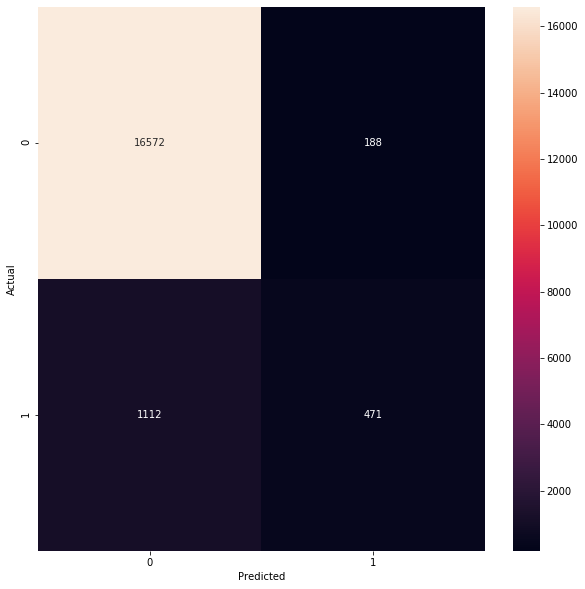

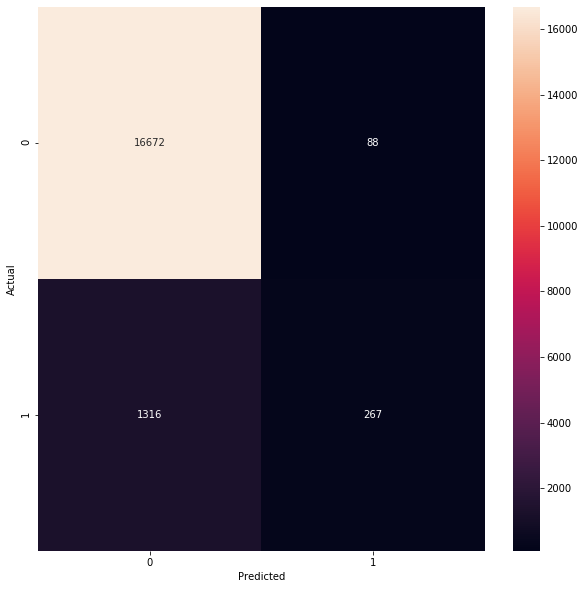

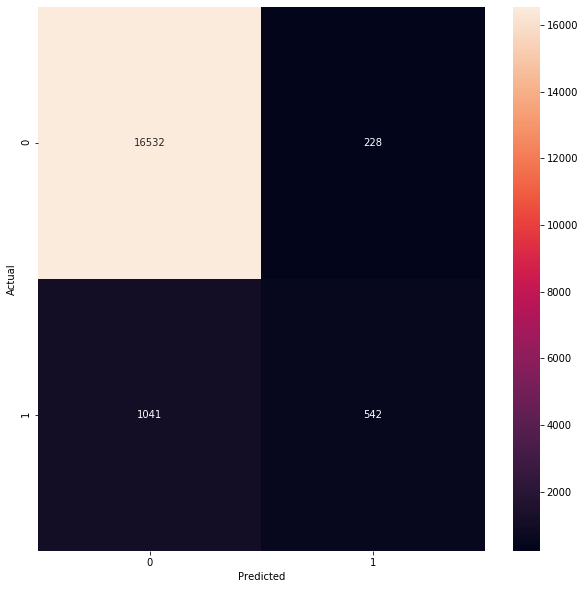

In [55]:
# Draw confusion matrix for each model 
for classifier in selected_clfs:

  # Load model saved
  clf = load('{}.joblib'.format(classifier)) 

  # Predict y based on X_test
  y_predict = clf.predict(X_test)

  # confusion matrix
  cm = confusion_matrix(y_test, y_predict)

  # Draw
  print(classifier)
  draw_conf_mat(cm)


## Models with Correction Of Imbalanced Data Using Undersampling

In [56]:
# create a dictionary of classifers with the hyperparameters you would like to try 
classifiers = {'XG_U': XGBClassifier(n_jobs = 1, learning_rate = .1, n_estimators = 100, objective = 'binary:hinge', booster='gbtree', max_depth = 7 ),
              'RF_U': RandomForestClassifier(n_estimators= 100, max_depth = 7),
              'LGB_U': LGBMClassifier(booster ='gbtree', n_estimators = 100, learning_rate = .1, max_depth = 7, objective ='binary')}

In [57]:
# keys for the classifiers 
selected_clfs = ['XG_U','RF_U','LGB_U']

new train test split for imbalanced data. Undersampling Data!

In [58]:
X_train_U, y_train_U = resampling_unbalanced(X_train, y_train, "under")

In [59]:
X_train_U.shape, y_train_U.shape

((12664, 598), (12664, 1))

In [60]:
clf_under_matrix = pd.DataFrame(columns = ['model', 'precision_test', 'recall_test', 'FPR_test', 'AUROC_test',
                                     'f1_test', 'f1_train', 'f1_CV'])

# for every classifer in the selected classifers list
for idx, classifier in enumerate(selected_clfs):

    # get the classifer and hyperparameters from the model
    clf = classifiers[classifier]

    # fit the model 
    clf.fit(X_train_U, y_train_U.values.ravel())
    print(f"-------- classifier being run is {classifier} ---------")

    print(f"-------- saving the the model ---------")
    # Write the model to file
    dump(clf, '{}.joblib'.format(classifier)) 

    print(f"-------- computing y_predict, y_prob, y_train_predict ---------")
    # prediction of y based on X_test
    y_predict = clf.predict(X_test)
    # prediction of y probability based on X_test
    y_proba = clf.predict_proba(X_test)[:,1]
    # prediction of y based on X_train
    y_train_predict = clf.predict(X_train_U)

    print(f"-------- creating the confusion matrix ---------") 
    # confusion matrix 
    cmat = confusion_matrix(y_test.values.ravel(), y_predict)
    # tp, fn, fp, tn
    tp = cmat[1,1]
    fn = cmat[1,0]
    fp = cmat[0,1]
    tn = cmat[0,0]

    print(f"-------- calculating the metrics ---------") 
    #precision score on test
    p_score_test = precision_score(y_test.values.ravel(), y_predict)

    #recall score on test
    r_score_test = tp/(tp+fn) 

    #FPR score on test
    fpr_test = fp/(fp+tn)

    #AUROC score on test
    auroc_test = roc_auc_score(y_test.values.ravel(), y_proba)

    #f1 score on test
    f1_test = f1_score(y_test.values.ravel(), y_predict)

    #f1 score on train
    f1_train = f1_score(y_train_U.values.ravel(), y_train_predict)

    #f1 score on cross validation 
    k_fold = 4
    f1_cv = cross_val_score(clf, X_train_U, y_train_U.values.ravel(), cv=k_fold, scoring = 'f1')
    print(f"Cross Validation is on {k_fold} folds.")

    print(f"-------- append values to the model matrix  ---------") 

    # append to matrix
    df2 = pd.DataFrame([[classifier,p_score_test,r_score_test, fpr_test, auroc_test, f1_test, f1_train, f1_cv]], 
                       columns=['model', 'precision_test', 'recall_test', 'FPR_test', 'AUROC_test',
                                     'f1_test', 'f1_train', 'f1_CV'])
    
    clf_under_matrix = pd.concat([df2, clf_under_matrix])


-------- classifier being run is XG_U ---------
-------- saving the the model ---------
-------- computing y_predict, y_prob, y_train_predict ---------
-------- creating the confusion matrix ---------
-------- calculating the metrics ---------
Cross Validation is on 4 folds.
-------- append values to the model matrix  ---------
-------- classifier being run is RF_U ---------
-------- saving the the model ---------
-------- computing y_predict, y_prob, y_train_predict ---------
-------- creating the confusion matrix ---------
-------- calculating the metrics ---------
Cross Validation is on 4 folds.
-------- append values to the model matrix  ---------
-------- classifier being run is LGB_U ---------
-------- saving the the model ---------
-------- computing y_predict, y_prob, y_train_predict ---------
-------- creating the confusion matrix ---------
-------- calculating the metrics ---------
Cross Validation is on 4 folds.
-------- append values to the model matrix  ---------


XG_U
RF_U
LGB_U


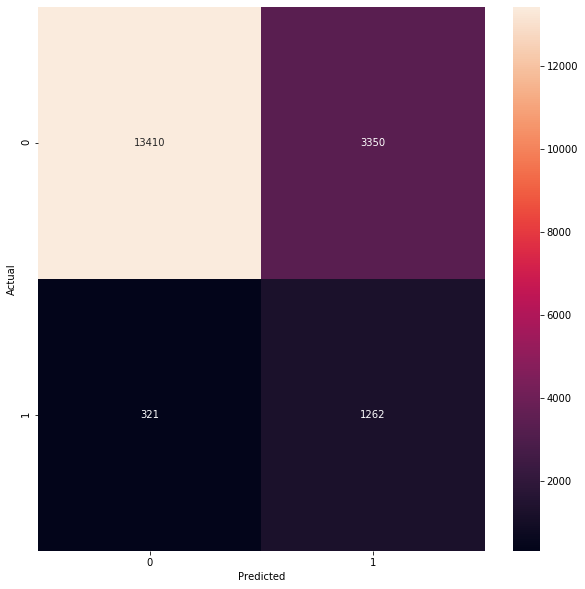

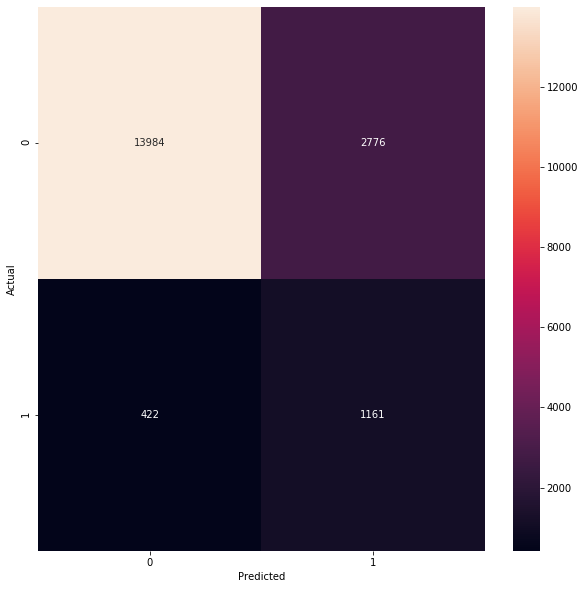

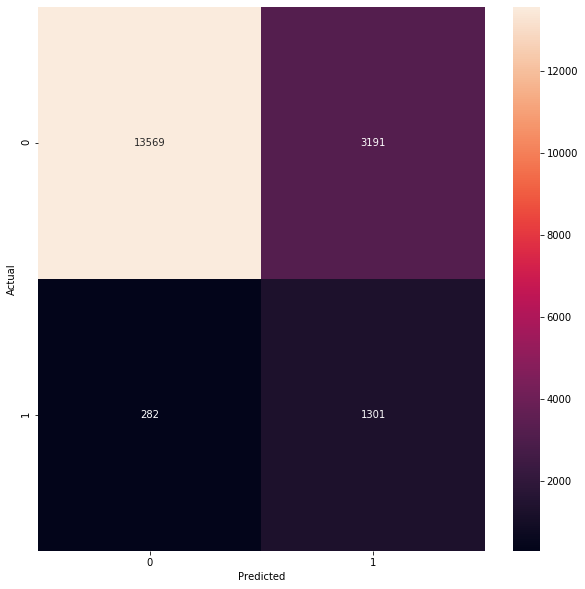

In [61]:
# Draw confusion matrix for each model 
for classifier in selected_clfs:

  # Load model saved
  clf = load('{}.joblib'.format(classifier)) 

  # Predict y based on X_test
  y_predict = clf.predict(X_test)

  # confusion matrix
  cm = confusion_matrix(y_test, y_predict)

  # Draw
  print(classifier)
  draw_conf_mat(cm)

In [62]:
clf_under_matrix

,model,precision_test,recall_test,FPR_test,AUROC_test,f1_test,f1_train,f1_CV
0,LGB_U,0.289626,0.821857,0.190394,0.899827,0.428313,0.913517,"[0.7997453040432982, 0.8190716766656142, 0.818..."
0,RF_U,0.294895,0.733418,0.165632,0.868802,0.420652,0.801756,"[0.7566297415240012, 0.7810218978102191, 0.773..."
0,XG_U,0.273634,0.797220,0.199881,0.798670,0.407425,0.957412,"[0.7914812460267006, 0.7989838043823436, 0.791..."


## Models with Correction Of Imbalanced Data Using Oversampling SMOTE 

In [63]:
# create a dictionary of classifers with the hyperparameters you would like to try 
classifiers = {'XG_O': XGBClassifier(n_jobs = 1, learning_rate = .1, n_estimators = 100, objective = 'binary:hinge', booster='gbtree', max_depth = 7 ),
              'RF_O': RandomForestClassifier(n_estimators= 100, max_depth = 7),
              'LGB_O': LGBMClassifier(booster ='gbtree', n_estimators = 100, learning_rate = .1, max_depth = 7, objective ='binary')}

In [64]:
selected_clfs = ['XG_O','RF_O','LGB_O']

In [65]:
X_train_O, y_train_O = resampling_unbalanced(X_train, y_train, "over")

In [66]:
X_train_O.shape, y_train_O.shape

((134076, 598), (134076, 1))

In [67]:
clf_over_matrix = pd.DataFrame(columns = ['model', 'precision_test', 'recall_test', 'FPR_test', 'AUROC_test',
                                     'f1_test', 'f1_train', 'f1_CV'])

# for every classifer in the selected classifers list
for idx, classifier in enumerate(selected_clfs):
    print(classifier)
    # get the classifer and hyperparameters from the model
    clf = classifiers[classifier]

    # fit the model 
    clf.fit(X_train_O,y_train_O.values.ravel())
    print(f"-------- classifier being run is {classifier} ---------")

    print(f"-------- saving the the model ---------")
    # Write the model to file
    dump(clf, '{}.joblib'.format(classifier)) 

    print(f"-------- computing y_predict, y_prob, y_train_predict ---------")
    # prediction of y based on X_test
    y_predict = clf.predict(X_test)
    # prediction of y probability based on X_test
    y_proba = clf.predict_proba(X_test)[:,1]
    # prediction of y based on X_train_O
    y_train_predict = clf.predict(X_train_O)

    print(f"-------- creating the confusion matrix ---------") 
    # confusion matrix 
    cmat = confusion_matrix(y_test.values.ravel(), y_predict)
    # tp, fn, fp, tn
    tp = cmat[1,1]
    fn = cmat[1,0]
    fp = cmat[0,1]
    tn = cmat[0,0]

    print(f"-------- calculating the metrics ---------") 
    #precision score on test
    p_score_test = precision_score(y_test.values.ravel(), y_predict)

    #recall score on test
    r_score_test = tp/(tp+fn) 

    #FPR score on test
    fpr_test = fp/(fp+tn)

    #AUROC score on test
    auroc_test = roc_auc_score(y_test.values.ravel(), y_proba)

    #f1 score on test
    f1_test = f1_score(y_test.values.ravel(), y_predict)

    #f1 score on train
    f1_train = f1_score(y_train_O.values.ravel(), y_train_predict)

    #f1 score on cross validation 
    k_fold = 4
    f1_cv = cross_val_score(clf, X_train_O, y_train_O.values.ravel(), cv=k_fold, scoring = 'f1')
    print(f"Cross Validation is on {k_fold} folds.")

    print(f"-------- append values to the model matrix  ---------") 

    # append to matrix
    df2 = pd.DataFrame([[classifier,p_score_test,r_score_test, fpr_test, auroc_test, f1_test, f1_train, f1_cv]], 
                       columns=['model', 'precision_test', 'recall_test', 'FPR_test', 'AUROC_test',
                                     'f1_test', 'f1_train', 'f1_CV'])
    
    clf_over_matrix = pd.concat([df2, clf_over_matrix])


XG_O
-------- classifier being run is XG_O ---------
-------- saving the the model ---------
-------- computing y_predict, y_prob, y_train_predict ---------
-------- creating the confusion matrix ---------
-------- calculating the metrics ---------
Cross Validation is on 4 folds.
-------- append values to the model matrix  ---------
RF_O
-------- classifier being run is RF_O ---------
-------- saving the the model ---------
-------- computing y_predict, y_prob, y_train_predict ---------
-------- creating the confusion matrix ---------
-------- calculating the metrics ---------
Cross Validation is on 4 folds.
-------- append values to the model matrix  ---------
LGB_O
-------- classifier being run is LGB_O ---------
-------- saving the the model ---------
-------- computing y_predict, y_prob, y_train_predict ---------
-------- creating the confusion matrix ---------
-------- calculating the metrics ---------
Cross Validation is on 4 folds.
-------- append values to the model matrix  ---

XG_O
RF_O
LGB_O


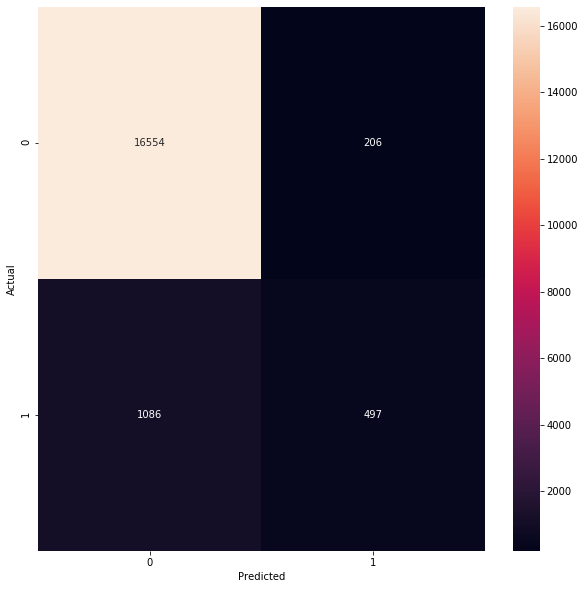

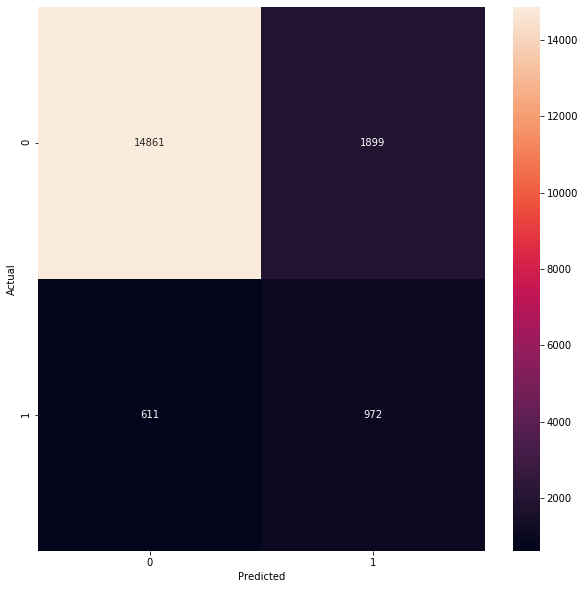

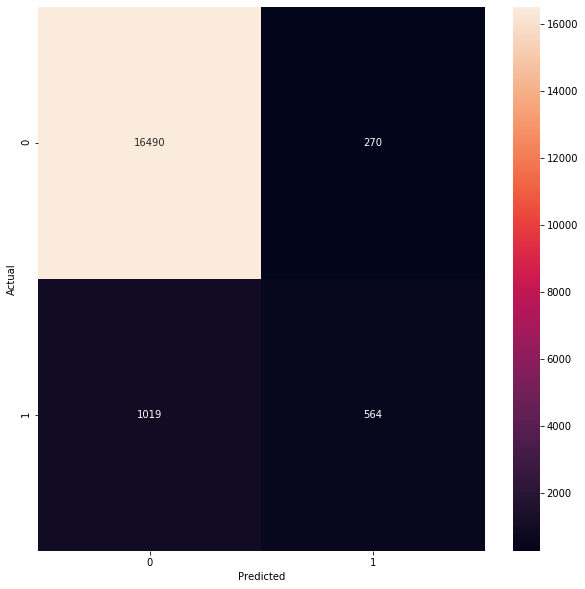

In [68]:
# Draw confusion matrix for each model 
for classifier in selected_clfs:

  # Load model saved
  clf = load('{}.joblib'.format(classifier)) 

  # Predict y based on X_test
  y_predict = clf.predict(X_test)

  # confusion matrix
  cm = confusion_matrix(y_test, y_predict)

  # Draw
  print(classifier)
  draw_conf_mat(cm)

In [69]:
clf_over_matrix.explode('f1_CV')

,model,precision_test,recall_test,FPR_test,AUROC_test,f1_test,f1_train,f1_CV
0,LGB_O,0.676259,0.356286,0.016110,0.894873,0.466694,0.965429,0.77045
0,LGB_O,0.676259,0.356286,0.016110,0.894873,0.466694,0.965429,0.988565
0,LGB_O,0.676259,0.356286,0.016110,0.894873,0.466694,0.965429,0.988045
0,LGB_O,0.676259,0.356286,0.016110,0.894873,0.466694,0.965429,0.987928
0,RF_O,0.338558,0.614024,0.113305,0.857186,0.436462,0.880838,0.829342
0,RF_O,0.338558,0.614024,0.113305,0.857186,0.436462,0.880838,0.890439
0,RF_O,0.338558,0.614024,0.113305,0.857186,0.436462,0.880838,0.886134
0,RF_O,0.338558,0.614024,0.113305,0.857186,0.436462,0.880838,0.885413
0,XG_O,0.706970,0.313961,0.012291,0.650835,0.434821,0.972175,0.772587
0,XG_O,0.706970,0.313961,0.012291,0.650835,0.434821,0.972175,0.990628


In [70]:
clf_under_matrix.explode('f1_CV')

,model,precision_test,recall_test,FPR_test,AUROC_test,f1_test,f1_train,f1_CV
0,LGB_U,0.289626,0.821857,0.190394,0.899827,0.428313,0.913517,0.799745
0,LGB_U,0.289626,0.821857,0.190394,0.899827,0.428313,0.913517,0.819072
0,LGB_U,0.289626,0.821857,0.190394,0.899827,0.428313,0.913517,0.818754
0,LGB_U,0.289626,0.821857,0.190394,0.899827,0.428313,0.913517,0.805276
0,RF_U,0.294895,0.733418,0.165632,0.868802,0.420652,0.801756,0.75663
0,RF_U,0.294895,0.733418,0.165632,0.868802,0.420652,0.801756,0.781022
0,RF_U,0.294895,0.733418,0.165632,0.868802,0.420652,0.801756,0.773873
0,RF_U,0.294895,0.733418,0.165632,0.868802,0.420652,0.801756,0.771259
0,XG_U,0.273634,0.797220,0.199881,0.798670,0.407425,0.957412,0.791481
0,XG_U,0.273634,0.797220,0.199881,0.798670,0.407425,0.957412,0.798984


In [71]:
clf_matrix.explode('f1_CV')

,model,precision_test,recall_test,FPR_test,AUROC_test,f1_test,f1_train,f1_CV
0,LGB,0.703896,0.342388,0.013604,0.901638,0.460688,0.594870,0.440461
0,LGB,0.703896,0.342388,0.013604,0.901638,0.460688,0.594870,0.462649
0,LGB,0.703896,0.342388,0.013604,0.901638,0.460688,0.594870,0.451915
0,LGB,0.703896,0.342388,0.013604,0.901638,0.460688,0.594870,0.464225
0,RF,0.752113,0.168667,0.005251,0.865725,0.275542,0.332188,0.274571
0,RF,0.752113,0.168667,0.005251,0.865725,0.275542,0.332188,0.273059
0,RF,0.752113,0.168667,0.005251,0.865725,0.275542,0.332188,0.249605
0,RF,0.752113,0.168667,0.005251,0.865725,0.275542,0.332188,0.288969
0,XG,0.714719,0.297536,0.011217,0.643160,0.420161,0.646855,0.402294
0,XG,0.714719,0.297536,0.011217,0.643160,0.420161,0.646855,0.418522


In [29]:
## Warnings seen on terminal

### [LightGBM] [Warning] Unknown parameter: booster
### [LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves

### Feature Importance

In [72]:
lgb = load("LGB.joblib")
baseline_importances = pd.DataFrame({'feature':X_wids.columns,'importance':np.round(lgb.feature_importances_,3)})
baseline_importances = baseline_importances.sort_values('importance',ascending=False).set_index('feature')
baseline_importances.head(600)

,importance
feature,
age,82
d1_heartrate_min,71
pre_icu_los_days,57
d1_resprate_min,51
bmi,49
d1_temp_max,47
d1_glucose_min,42
d1_platelets_min,39
d1_sodium_max,38


In [42]:
pd.set_option("display.max_rows", None)